# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)
## Data Exploration

**Imports**

In [100]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.express as px

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [101]:
OUT_DIR = "../out"        
DF_FILE       = "nfp_df.parquet"
DF_FULL_FILE  = "nfp_df_full.parquet"
DF_FIRMS_FILE       = "nfp_firms_df.parquet"
DF_FIRMS_FULL_FILE  = "nfp_firms_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")
df_firms       = pd.read_parquet(os.path.join(OUT_DIR, DF_FIRMS_FILE),      engine="pyarrow")
df_firms_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FIRMS_FULL_FILE), engine="pyarrow")


print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)
print("df_firms shape     :", df_firms.shape)
print("df_firms_full shape:", df_firms_full.shape)

df shape     : (17046, 10)
df_full shape: (19375, 10)
df_firms shape     : (16943, 9)
df_firms_full shape: (19250, 9)


In [71]:
df_full.head()

,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2003-06-06,2003-05-31,-17.0,-30.0,Alessandro Truppia,Aletti Gestielle Sgr Spa,-15.0,2003-06-04,13.0,2.0
1,2003-06-06,2003-05-31,-17.0,-30.0,Alison Lynn Reaser,Point Loma Nazarene University,-15.0,2003-05-30,13.0,2.0
2,2003-06-06,2003-05-31,-17.0,-30.0,Anthony Chan,JPMorgan Chase Bank,-70.0,2003-05-30,13.0,-53.0
3,2003-06-06,2003-05-31,-17.0,-30.0,Aurelio Maccario,UniCredit Spa,-9.0,2003-05-30,13.0,8.0
4,2003-06-06,2003-05-31,-17.0,-30.0,Avery Shenfeld,Canadian Imperial Bank of Commerce,-20.0,2003-05-30,13.0,-3.0


**Data Exploration**

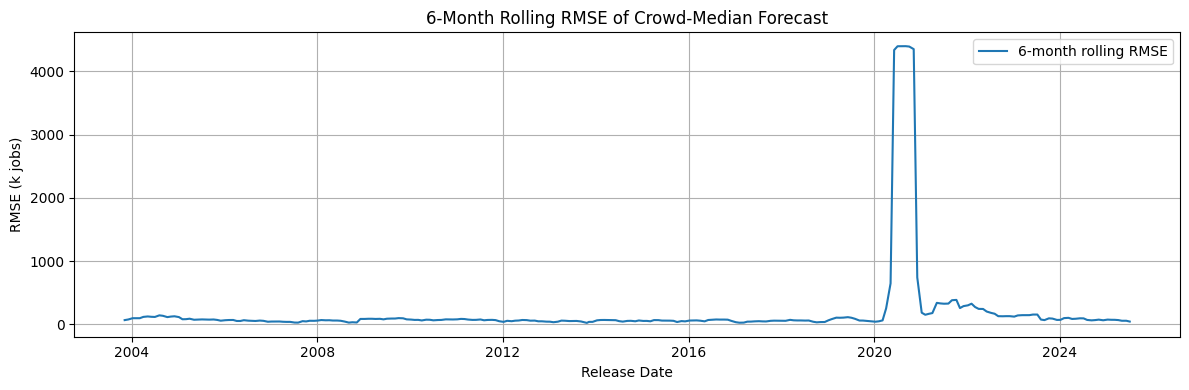

In [72]:
# Build one-row-per-release table of median forecast vs actual
median_vs_actual = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),
                actual      =("actual",   "first"))
           .dropna()
           .sort_index()
)

# Compute forecast error and rolling RMSE
median_vs_actual["err"] = median_vs_actual["crowd_median"] - median_vs_actual["actual"]

WINDOW = 6                       
median_vs_actual[f"rmse_{WINDOW}m"] = (
    median_vs_actual["err"]
      .rolling(WINDOW, min_periods=WINDOW)
      .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

# Plot rolling RMSE of the crowd median
plt.figure(figsize=(12, 4))
plt.plot(median_vs_actual.index,
         median_vs_actual[f"rmse_{WINDOW}m"],
         label=f"{WINDOW}-month rolling RMSE")

plt.title(f"{WINDOW}-Month Rolling RMSE of Crowd-Median Forecast")
plt.xlabel("Release Date")
plt.ylabel("RMSE (k jobs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

COVID (~2020-2022) should be filtered out if we want accuracy in naive point forecast

Contiguity windows:   0%|          | 0/3 [00:00<?, ?it/s]

6-mo tracking:   0%|          | 0/261 [00:00<?, ?it/s]

12-mo tracking:   0%|          | 0/255 [00:00<?, ?it/s]

24-mo tracking:   0%|          | 0/243 [00:00<?, ?it/s]

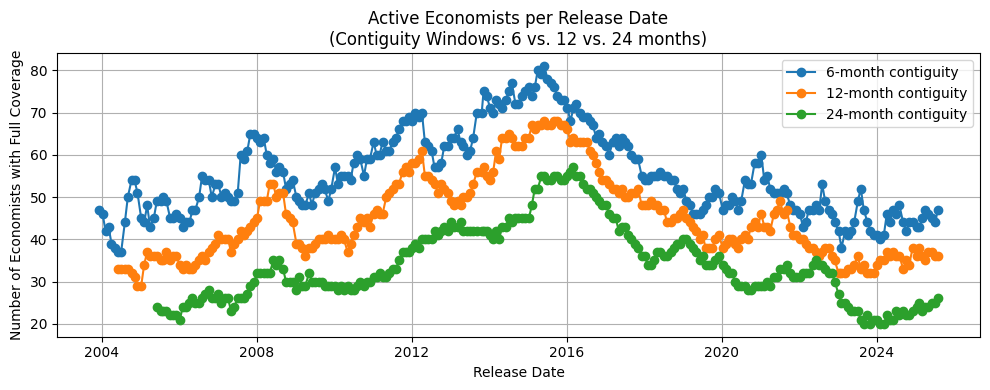

In [73]:
# prepare dates
dates = sorted(df_full["release_date"].unique())

contiguity_windows = [6, 12, 24]
active_counts = {}

for window in tqdm(contiguity_windows, desc="Contiguity windows"):
    counts = []
    for idx in tqdm(range(window, len(dates)),
                    desc=f"{window}-mo tracking", leave=False):
        t            = dates[idx]
        window_dates = dates[idx-window:idx]
        hist         = df_full[df_full["release_date"].isin(window_dates)]

        # strict contiguity: economist must appear in *every* month
        coverage = (
            hist.groupby("economist")["release_date"]
                .nunique()
        )
        valid_econs = coverage[coverage == window]

        counts.append((t, len(valid_econs)))

    active_counts[window] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts]
    )

    
plt.figure(figsize=(10, 4))
for window, series in active_counts.items():
    plt.plot(
        series.index,
        series.values,
        marker='o',
        label=f"{window}-month contiguity"
    )

plt.title("Active Economists per Release Date\n(Contiguity Windows: 6 vs. 12 vs. 24 months)")
plt.xlabel("Release Date")
plt.ylabel("Number of Economists with Full Coverage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Directional exploration**

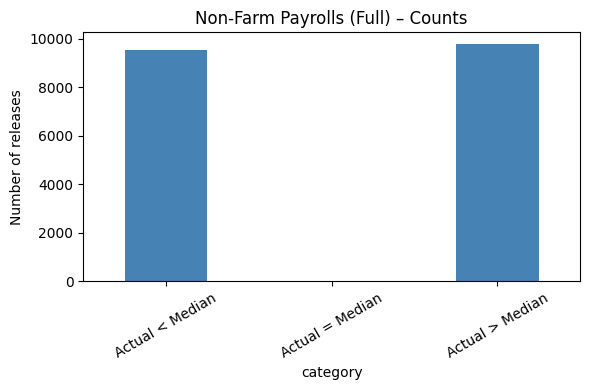

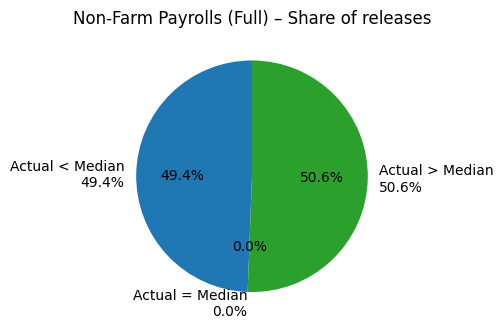

In [74]:
def plot_nfp_direction(df_full: pd.DataFrame, title: str = "NFP (Full)") -> None:
    """
    Creates:
      1) bar chart of counts
      2) pie chart of shares
    for the breakdown:
        • actual <  median_forecast
        • actual =  median_forecast
        • actual >  median_forecast
    """
    subset = df_full.dropna(subset=["actual", "median_forecast"]).copy()

    # classify releases
    subset["category"] = np.where(
        subset["actual"] < subset["median_forecast"],  "Actual < Median",
        np.where(subset["actual"] > subset["median_forecast"],
                 "Actual > Median",
                 "Actual = Median")
    )

    order = ["Actual < Median", "Actual = Median", "Actual > Median"]
    counts = (subset["category"]
              .value_counts()
              .reindex(order, fill_value=0))

    # bar chart
    counts.plot.bar(figsize=(6, 4), rot=30, color="steelblue")
    plt.title(f"{title} – Counts")
    plt.ylabel("Number of releases")
    plt.tight_layout()
    plt.show()

    # pie chart
    plt.figure(figsize=(5, 5))
    plt.pie(
        counts.values,
        labels=[f"{lab}\n{val/len(subset):.1%}" for lab, val in zip(order, counts.values)],
        autopct="%1.1f%%",
        startangle=90
    )
    plt.title(f"{title} – Share of releases")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# call the function on your NFP DataFrame
plot_nfp_direction(df_full, "Non‑Farm Payrolls (Full)")


# Most accurate forecasters over time

In [ ]:
# # -------------------------------------------------------------
# # Bar-chart race: top-10 rolling RMSE firms (12-release window)
# # Contiguity filter – forecaster must appear in ALL 12 months
# # -------------------------------------------------------------
# import pandas as pd, numpy as np, plotly.express as px

# ROLL_WINDOW = 12
# TOP_K       = 10
# PANEL       = df_full          # or df for COVID-filtered

# dates   = np.sort(PANEL["release_date"].unique())
# frames  = []

# for idx in range(ROLL_WINDOW, len(dates)):
#     t_date = dates[idx]
#     hist   = PANEL[PANEL["release_date"].isin(dates[idx-ROLL_WINDOW:idx])]

#     # contiguity check (complete 12/12 forecasts) – use firm grouping
#     complete = (hist.groupby("firm")["forecast"]
#                     .apply(lambda s: s.notna().all()))
#     firms = complete[complete].index
#     if firms.empty:
#         continue

#     rmse = (hist[hist["firm"].isin(firms)]
#             .groupby("firm")["error"]
#             .apply(lambda s: np.sqrt(np.mean(s**2)))
#             .dropna()
#             .rename("RMSE"))

#     if rmse.empty:
#         continue

#     top = rmse.nsmallest(TOP_K).reset_index()   # firm, RMSE
#     top["date"] = t_date
#     frames.append(top)

# viz_df = pd.concat(frames, ignore_index=True)

# fig = px.bar(viz_df,
#              x="RMSE", y="firm",
#              orientation="h",
#              color="firm",
#              animation_frame="date",
#              animation_group="firm",
#              title=f"Rolling {ROLL_WINDOW}-release RMSE – Top {TOP_K} firms")

# fig.update_layout(yaxis={'categoryorder': 'total ascending'},
#                   xaxis_title="RMSE (k jobs)",
#                   yaxis_title="Firm",
#                   legend_title="Firm",
#                   height=600)

# fig.show()


**Visualize distribution of COVID-filtered dataframe**

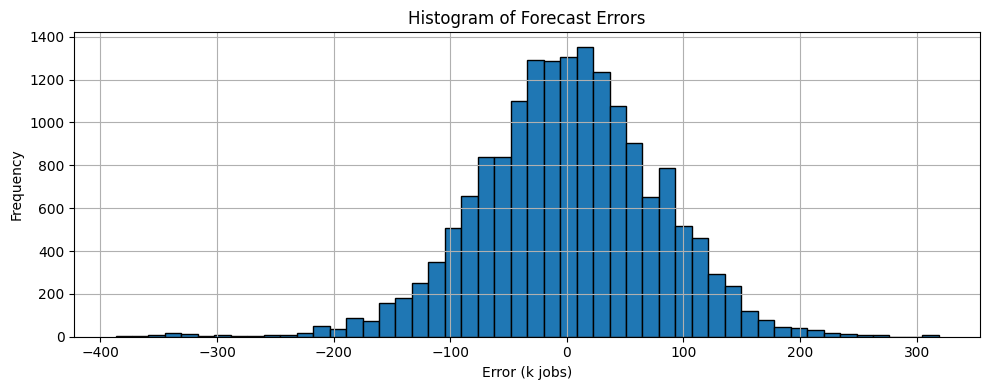

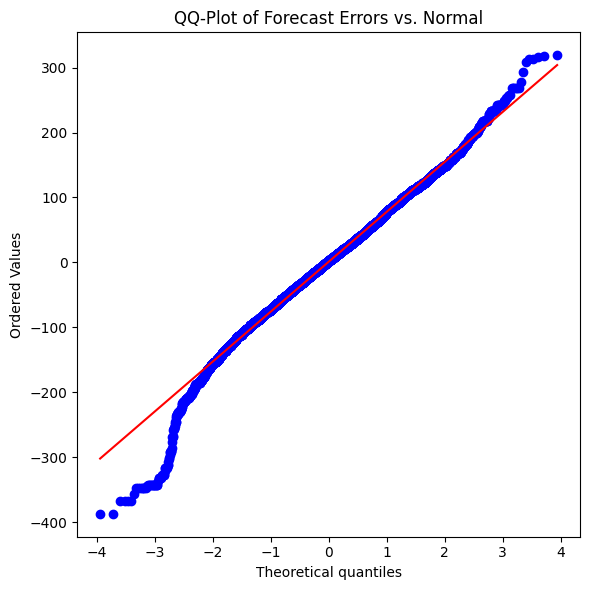

In [76]:
# Error distribution: histogram and QQ plot of forecast errors 
errors = df["error"].dropna().values

plt.figure(figsize=(10, 4))
plt.hist(errors, bins=50, edgecolor="black")
plt.title("Histogram of Forecast Errors")
plt.xlabel("Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("QQ‐Plot of Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()

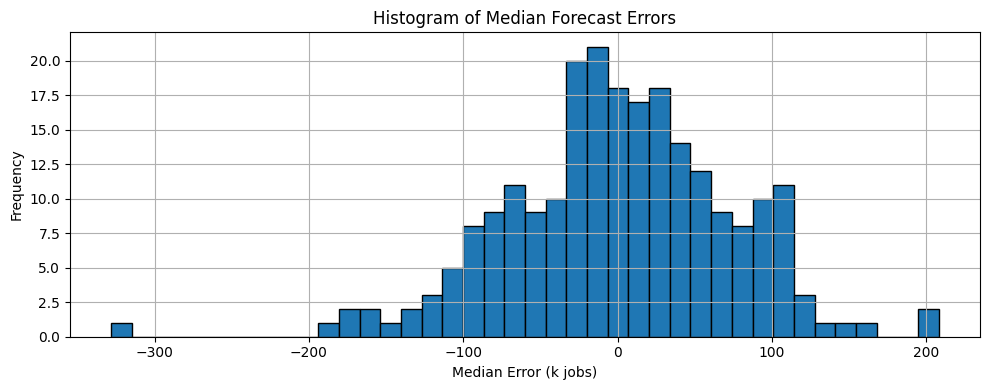

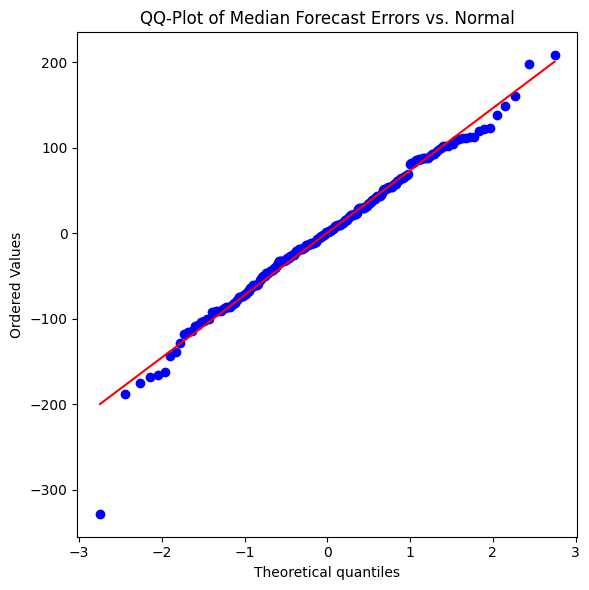

In [77]:
# Compute median forecast errors (one value per release)
median_errors = (
    df
      .drop_duplicates('release_date')                # keep one row per release
      .assign(median_err=lambda d: d['median_forecast'] - d['actual'])
      ['median_err']
      .dropna()                                       # <-- filter NaNs (July 2025)
      .values
)


# Histogram of median forecast errors
plt.figure(figsize=(10, 4))
plt.hist(median_errors, bins=40, edgecolor='black')
plt.title("Histogram of Median Forecast Errors")
plt.xlabel("Median Error (k jobs)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# QQ‐plot of median errors against a Normal distribution
plt.figure(figsize=(6, 6))
stats.probplot(median_errors, dist='norm', plot=plt)
plt.title("QQ‐Plot of Median Forecast Errors vs. Normal")
plt.tight_layout()
plt.show()


**Normality tests**

Unlikely given fat-tailed nature. We include this for completeness.

In [78]:
# --- Jarque-Bera on economist-level errors ----
jb_e_stat, jb_e_p = jarque_bera(errors)
print(f"Jarque–Bera (all economist errors) :  JB = {jb_e_stat:,.2f},  p = {jb_e_p:.4f}")

# --- Jarque-Bera on MEDIAN forecast errors -------------------------
jb_m_stat, jb_m_p = jarque_bera(median_errors)
print(f"Jarque–Bera (median errors)        :  JB = {jb_m_stat:,.2f},  p = {jb_m_p:.4f}")

if jb_m_p < 0.05:
    print("→ Reject normality of median errors at the 5 % level.")
else:
    print("→ Cannot reject normality of median errors at the 5 % level.")
    
    
# for reference: JB stat threshold for 5% threshold is approx. 6 

Jarque–Bera (all economist errors) :  JB = 1,023.49,  p = 0.0000
Jarque–Bera (median errors)        :  JB = 22.63,  p = 0.0000
→ Reject normality of median errors at the 5 % level.


## Student-t distribution test

KS and CvM goodness-of-fit test for student's t

Null: The sample comes from a fully-specified student-t CDF

KS emphasizes the worst mismatch, while CvM checks for a match in the overall shape. 

In [79]:
# fitting overall forecast errors 

# fit parameters via MLE
nu_hat, loc_hat, scale_hat = st.t.fit(errors)

# Kolmogorov–Smirnov against fitted t
ks_stat, ks_p = st.kstest(errors, 't', args=(nu_hat, loc_hat, scale_hat))
print(f"K–S vs fitted t :  D = {ks_stat:.3f},  p = {ks_p:.4f}")

# Cramér–von Mises test (works for any callable CDF)
t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
cvm_res = st.cramervonmises(errors, t_cdf)
print(f"CvM statistic   :  W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")

K–S vs fitted t :  D = 0.012,  p = 0.0182
CvM statistic   :  W² = 0.191,  p = 0.2852


Student-t is adequate to model forecast errors in COVID-filtered dataframe. CvM denotes no meaningful deviation. KS rejection likely a large-sample artefact; visual inspection only shows miniscule departures.

In [80]:
# fit parameters via MLE
nu_hat, loc_hat, scale_hat = st.t.fit(median_errors)

# Kolmogorov–Smirnov against fitted t
ks_stat, ks_p = st.kstest(median_errors, 't', args=(nu_hat, loc_hat, scale_hat))
print(f"K–S vs fitted t :  D = {ks_stat:.3f},  p = {ks_p:.4f}")

# Cramér–von Mises test (works for any callable CDF)
t_cdf = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
cvm_res = st.cramervonmises(median_errors, t_cdf)
print(f"CvM statistic   :  W² = {cvm_res.statistic:.3f},  p = {cvm_res.pvalue:.4f}")

K–S vs fitted t :  D = 0.036,  p = 0.9143
CvM statistic   :  W² = 0.022,  p = 0.9947


For median errors, student-t models errors well. Both KS and CvM do not reject null (no statistical evidence that median-error distribution differs from student-t).

**Overlay fitted t PDF (Forecast errors, median errors)**

- Use parameters we found previously via MLE to fit the student-t
- Check curve against histogram if parametric model under or overestimates mass 

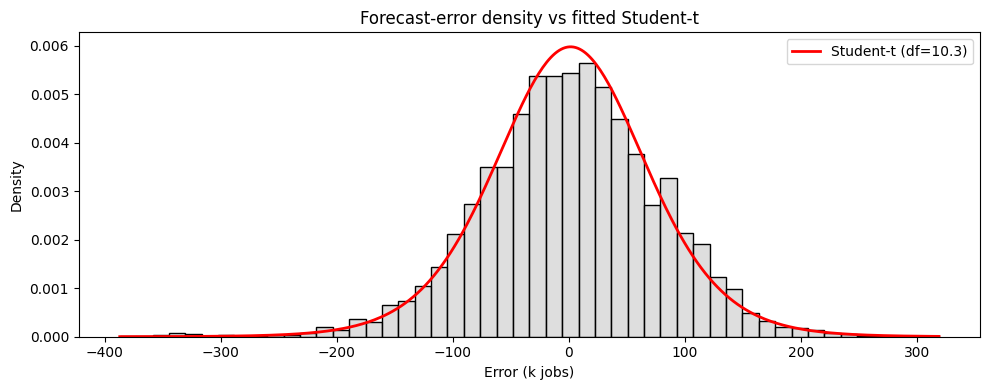

In [81]:
xgrid = np.linspace(errors.min(), errors.max(), 400)
pdf_t = st.t.pdf(xgrid, df=nu_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10,4))
sns.histplot(errors, bins=50, stat="density", edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2, label=f"Student-t (df={nu_hat:,.1f})")
plt.title("Forecast-error density vs fitted Student-t")
plt.xlabel("Error (k jobs)"); plt.ylabel("Density")
plt.legend(); plt.tight_layout(); plt.show()

No obvious bias present. Red t curve hugs grey bars well.

Let's try for median forecast errors:

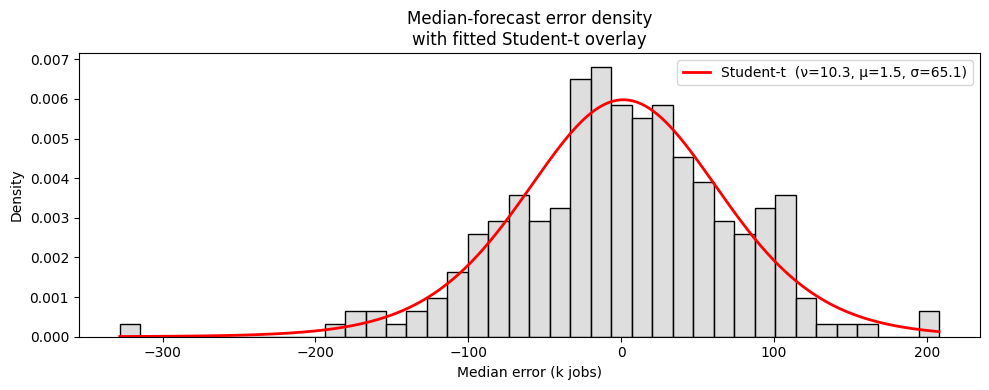

In [82]:
# MLE fit
nu_hat_median, loc_hat_median, scale_hat_median = st.t.fit(median_errors)

# Histogram + fitted Student-t PDF 
xgrid = np.linspace(median_errors.min(), median_errors.max(), 400)
pdf_t = st.t.pdf(xgrid,
                 df=nu_hat_median,
                 loc=loc_hat_median,
                 scale=scale_hat_median)

plt.figure(figsize=(10,4))
sns.histplot(median_errors,
             bins=40, stat="density",
             edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, c="red", lw=2,
         label=f"Student-t  (ν={nu_hat_median:.1f}, μ={loc_hat_median:.1f}, σ={scale_hat_median:.1f})")
plt.title("Median-forecast error density\nwith fitted Student-t overlay")
plt.xlabel("Median error (k jobs)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


**Tail-probability calibration plot**
- Two sided tail probability for each error 
- For every absolute error: Under the fitted student-t, what is the probability of seeing a value at least as extreme as this? 
- Output p-value between 0 and 1 
- Sorted p-values plotted against uniform [0,1] grid
- If fitted distribution were perfect, empirical CDF would hug the diagonal

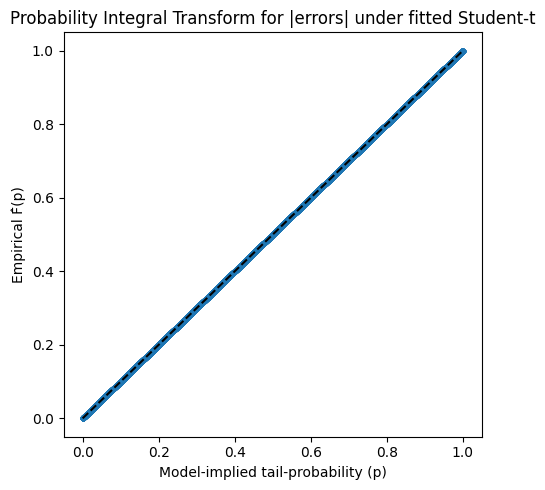

In [83]:
tail_pvals = 2*(1 - st.t.cdf(np.abs(errors), df=nu_hat, loc=0, scale=scale_hat))
tail_pvals.sort()
n = len(tail_pvals)

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,1,n), np.arange(1,n+1)/n, marker=".", ls="")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("Model-implied tail-probability (p)"); plt.ylabel("Empirical F̂(p)")
plt.title("Probability Integral Transform for |errors| under fitted Student-t")
plt.tight_layout(); plt.show()


**Contribution of tails to RMSE**

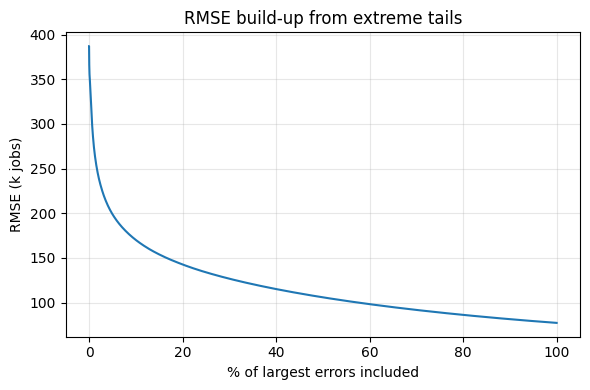

In [84]:
abs_err = np.abs(errors)
sorted_abs = np.sort(abs_err)[::-1]           # biggest first
cum_mse = np.cumsum(sorted_abs**2)
cum_rmse = np.sqrt(cum_mse / np.arange(1,len(errors)+1))

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(errors)+1)/len(errors)*100, cum_rmse)
plt.xlabel("% of largest errors included"); plt.ylabel("RMSE (k jobs)")
plt.title("RMSE build-up from extreme tails"); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

Few gigantic errors dominate RMSE; heavy tail risk --> consider trimming (winsorize) or robust loss (student-t, Huber, quantile)

**Skewness vs. time**

- For every month t, compute sample skewness of previous 12 releases 
- Plot rolling window skewness 

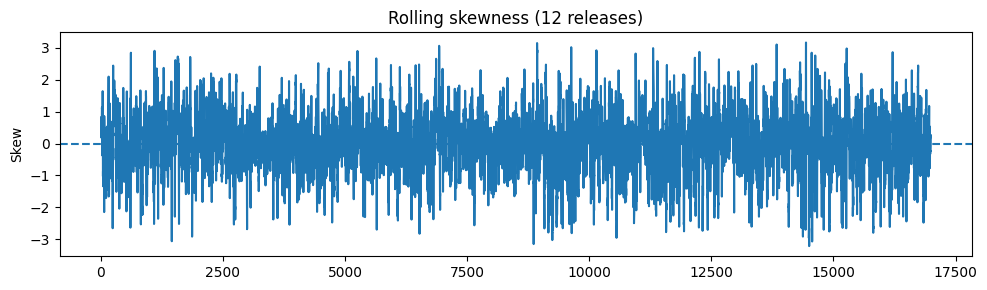

In [85]:
roll_skew = pd.Series(errors).rolling(12).skew()
roll_skew.plot(figsize=(10,3), title="Rolling skewness (12 releases)")
plt.axhline(0, ls="--"); plt.ylabel("Skew"); plt.tight_layout(); plt.show()

Forecasts centered correctly on average. Spikes represent fat-tail risk.

**Student-t implied parameters (forecast errors, median errors)**

In [86]:
nu, loc, scale = nu_hat, loc_hat, scale_hat       # from st.t.fit(...)
var   = scale**2 * nu / (nu-2)        if nu > 2 else np.inf
kurt  = 6 / (nu-4)                    if nu > 4 else np.inf

print("Student-t parameters:")
print(f"nu: {nu}")
print(f"loc: {loc}")
print(f"scale: {scale}\n")

print("Moments:")
print(f"Mean = {loc_hat}")
print(f"Var    = {var:6.2f}")
print(f"Skewness = 0 (Symmetric)")
print(f"Ex.Kurt= {kurt:6.2f}")

Student-t parameters:
nu: 10.256979027148988
loc: 1.4945629830585245
scale: 65.12802567537096

Moments:
Mean = 1.4945629830585245
Var    = 5269.07
Skewness = 0 (Symmetric)
Ex.Kurt=   0.96


**Confidence Intervals - Toy Example**

Toy example of how we can compute confidence intervals for point forecasts bases off student-t error distribution

In [87]:
def student_t_interval(point_forecast, nu=7.418464693617684, loc=5.192769902441414, scale=69.74945424622365, level=0.95):
    """Return lower, upper bounds of a (1-α) prediction interval."""
    q = st.t.ppf(1 - (1 - level)/2, df=nu)  # two-sided critical value
    lower = point_forecast + loc - q * scale
    upper = point_forecast + loc + q * scale
    return lower, upper

In [88]:
# example for the upcoming release
y_hat = 180        # example smart forecast
low, high = student_t_interval(
    y_hat, nu_hat, loc_hat, scale_hat, level=0.9
)
print(f"90 % interval: ({low:.1f},{high:.1f}) k")

90 % interval: (63.8,299.2) k


**Cross-Sectional Spread**

In this section, we'll perform some tests to check if cross-sectional spread can inform us about confidence interval widths. 


COVID panel:
  Pearson  r =  0.168  (p = 0.0105)
  Spearman ρ =  0.182  (p = 0.0057)

Full panel:
  Pearson  r =  0.710  (p = 0.0000)
  Spearman ρ =  0.347  (p = 0.0000)


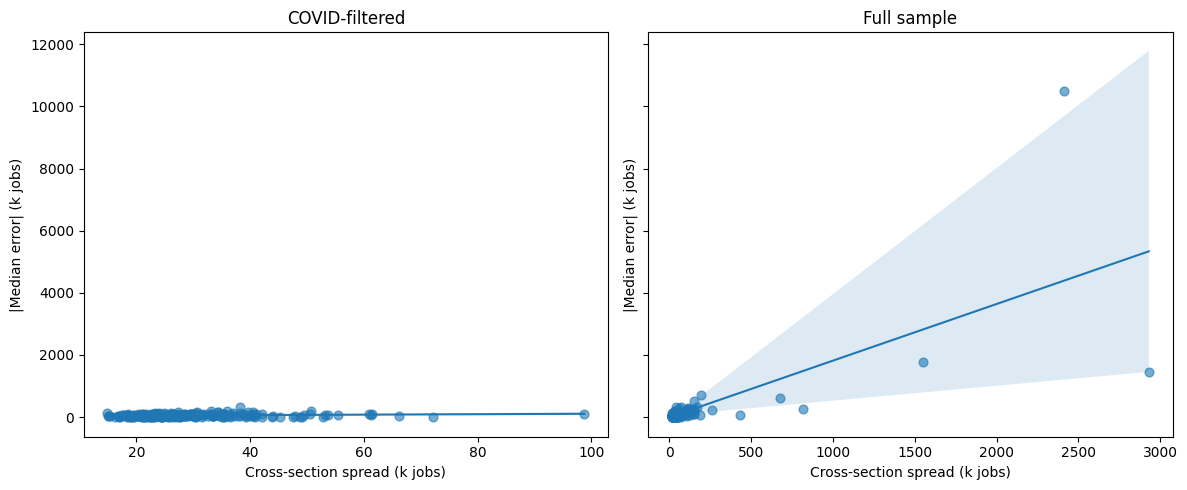

In [89]:
# Helper to build (date, spread, abs_err) table
def build_spread_df(panel: pd.DataFrame, label: str) -> pd.DataFrame:
    """Return DataFrame with release_date, spread, abs_err for a panel."""
    # cross-sectional std of forecasts
    spread = (panel.groupby("release_date")["forecast"]
                     .std(ddof=0)                # population SD
                     .rename("spread"))
    # median forecast & actual
    med_act = (panel.groupby("release_date")
                     .agg(median_fc=("forecast", "median"),
                          actual    =("actual",   "first")))
    med_act["abs_err"] = (med_act["median_fc"] - med_act["actual"]).abs()
    out = med_act.join(spread).reset_index()
    out["panel"] = label
    return out.dropna(subset=["spread", "abs_err"])         # ensure SD defined

covid_tbl  = build_spread_df(df,       "COVID")
full_tbl   = build_spread_df(df_full,  "Full")

# Correlation summary
for tbl, name in [(covid_tbl, "COVID"), (full_tbl, "Full")]:
    pearson  = stats.pearsonr(tbl["spread"], tbl["abs_err"])
    spearman = stats.spearmanr(tbl["spread"], tbl["abs_err"])
    print(f"\n{name} panel:")
    print(f"  Pearson  r = {pearson.statistic:6.3f}  (p = {pearson.pvalue:.4f})")
    print(f"  Spearman ρ = {spearman.statistic:6.3f}  (p = {spearman.pvalue:.4f})")


# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, tbl, title in zip(axs, [covid_tbl, full_tbl], ["COVID-filtered", "Full sample"]):
    sns.regplot(data=tbl, x="spread", y="abs_err",
                scatter_kws={"alpha":0.6, "s":40}, line_kws={"linewidth":1.5}, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cross-section spread (k jobs)")
    ax.set_ylabel("|Median error| (k jobs)")

plt.tight_layout()
plt.show()

Note: shaded blue cloud represents 95% confidence interval for the expected value of abs_err at each spread 

In [90]:
# Influence diagnostics

# fit ols, get cook's D
X = sm.add_constant(full_tbl["spread"])
model      = sm.OLS(full_tbl["abs_err"], X).fit()
full_tbl["cooksD"] = model.get_influence().cooks_distance[0]

# Flag influential points:  D_i > 4 / n
n_obs          = len(full_tbl)
cutoff         = 4 / n_obs
infl_tbl       = full_tbl[full_tbl["cooksD"] > cutoff]        # keep only influential
infl_tbl       = infl_tbl.sort_values("cooksD", ascending=False)

print(f"Cook’s-D cutoff (4/n) = {cutoff:.4f}  |  n influential = {len(infl_tbl)}")

# Display the influential releases
cols_to_show = ["release_date", "spread", "abs_err", "cooksD"]
display(infl_tbl[cols_to_show]
        .style.format({"spread": "{:.1f}", "abs_err": "{:.1f}", "cooksD": "{:.4f}"}))

Cook’s-D cutoff (4/n) = 0.0150  |  n influential = 5


,release_date,spread,abs_err,cooksD
204,2020-06-05 00:00:00,2413.3,10509.0,59.3170
203,2020-05-08 00:00:00,2930.9,1463.0,58.9163
205,2020-07-02 00:00:00,1549.1,1771.0,0.4313
206,2020-08-07 00:00:00,817.9,263.0,0.1332
202,2020-04-03 00:00:00,676.3,601.0,0.0237


- Information content exists in the cross-section: a wider cross-section signals higher risk that the median will miss
- Regime dependency: Relationship strengthens dramatically in crisis periods (see much higher Pearson correlation) when both disagreement and errors explode. In full sample, Spearman << Pearson, telling us that the strength of the linear fit is dominated by a subset of extreme-error months (refer to co).
- Complementary to current GARCH/EWMA approaches: GARCH reacts **after** a big miss. Cross-sectional spread is available before the print 
- Could try combining the two to improve tail coverage in crisis regimes

*Regression Test*

Run OLS with robust (Newey-West) standard errors to model spread-median error relationship. 

ln | error_t | = beta_0 + beta_1 * ln(spread_t) + epsilon_t

In [91]:
# covid-filtered data
tbl = covid_tbl.copy()

# Keep only rows with strictly positive spread *and* abs_err
tbl = tbl[(tbl["spread"]  > 0) & (tbl["abs_err"]  > 0)]

# Guard against lingering NaN / inf
tbl = tbl.replace([np.inf, -np.inf], np.nan).dropna(subset=["spread", "abs_err"])

print(f"Rows in regression: {len(tbl)}")

# --- log–log regression ---
print("Log–log regression, COVID‑filtered panel:")
y = np.log(tbl["abs_err"])
X = sm.add_constant(np.log(tbl["spread"]))
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
print(ols.summary())

# # --- level‑level regression ---
# print("\nLevel regression, COVID‑filtered panel:")
# y = tbl["abs_err"]
# X = sm.add_constant(tbl["spread"])
# ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
# print(ols.summary())


Rows in regression: 228
Log–log regression, COVID‑filtered panel:
                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.935
Date:                Thu, 31 Jul 2025   Prob (F-statistic):              0.166
Time:                        10:06:14   Log-Likelihood:                -333.27
No. Observations:                 228   AIC:                             670.5
Df Residuals:                     226   BIC:                             677.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [92]:
# full panel 

tbl = full_tbl.copy()

# Keep only rows with strictly positive spread *and* abs_err
tbl = tbl[(tbl["spread"]  > 0) & (tbl["abs_err"]  > 0)]

# Guard against lingering NaN / inf
tbl = tbl.replace([np.inf, -np.inf], np.nan).dropna(subset=["spread", "abs_err"])

print(f"Rows in regression: {len(tbl)}")

# --- log–log regression ---
print("Log–log regression, Full panel:")
y = np.log(tbl["abs_err"])
X = sm.add_constant(np.log(tbl["spread"]))
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
print(ols.summary())

# --- level‑level regression ---
print("\nLevel regression, Full panel:")
y = tbl["abs_err"]
X = sm.add_constant(tbl["spread"])
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
print(ols.summary())


Rows in regression: 264
Log–log regression, Full panel:
                            OLS Regression Results                            
Dep. Variable:                abs_err   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     113.9
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           2.57e-22
Time:                        10:06:14   Log-Likelihood:                -392.73
No. Observations:                 264   AIC:                             789.5
Df Residuals:                     262   BIC:                             796.6
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

- Disagreement (large spread in the cross-section) adds signal, but mostly in crisis extremes (R2 is low outside of that)
- in 2020-2022, spread is critical. Forecasters disagree widely and errors explode
- Let's try a routine where in normal times, we use the COVID-filtered B_1 multiplier, and then use a larger multiplier using a crisis indicator (spread above historical 95th pct)

**Check Student-t diagnostics for smart forecast**

Build smart series:   0%|          | 0/219 [00:00<?, ?it/s]


Built smart-forecast series: 218 releases

Fitted Student-t parameters (MLE)
nu (df)   :  12.25
mu (loc)  :   1.58  k jobs
sigma     :  64.05  k jobs

Sample vs implied theoretical moments


,Sample,Student_t
Mean,0.781868,1.583583
Variance,4949.886554,4902.917097
Skew,-0.313922,0.000000
ExKurtosis,1.076269,0.726939



Goodness-of-fit tests
Jarque-Bera          : JB =      14.10, p = 0.0009
Kolmogorov-Smirnov   : D  =      0.026, p = 0.9974
Cramer-von Mises     : W2 =      0.029, p = 0.9789


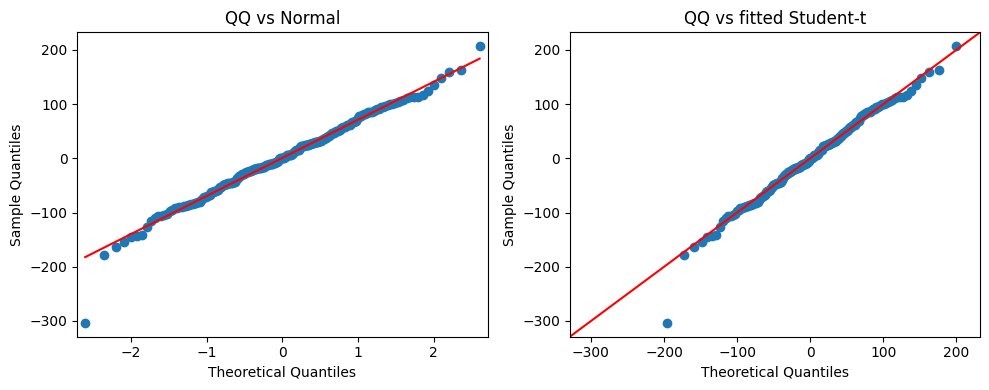

Rolling coverage:   0%|          | 0/182 [00:00<?, ?it/s]


Rolling-origin coverage (expanding Student-t)


,Nominal,Empirical
0,0.500,0.511
1,0.600,0.582
2,0.700,0.670
3,0.800,0.764
4,0.900,0.896
5,0.950,0.945
6,0.990,0.984


In [93]:
# ==============================================================
# 12-month inverse-MSE smart-forecast diagnostics 
# ==============================================================

# ------------------------------------------------------------------
# 0.  Select the panel you want to test
# ------------------------------------------------------------------
PANEL = df            # use df  (COVID-filtered)  or df_full (full sample)

# ------------------------------------------------------------------
# 1. Build 12-month smart forecast & error series
# ------------------------------------------------------------------
LOOKBACK = 12
RIDGE    = 1e-6       # stabiliser for 1/MSE weights

dates_all = np.sort(PANEL["release_date"].unique())
records   = []

for idx in tqdm(range(LOOKBACK, len(dates_all)), desc="Build smart series"):
    t       = dates_all[idx]
    window  = dates_all[idx - LOOKBACK : idx]

    hist = PANEL[PANEL["release_date"].isin(window)]

    # economists with forecasts for ALL months in the window
    valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs = valid[valid].index
    if econs.empty:
        continue

    # mean squared error for each economist
    mse = (hist[hist["economist"].isin(econs)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(np.square(s))))
    weights = 1.0 / (mse + RIDGE)
    weights /= weights.sum()

    # current forecasts from those economists
    cur = PANEL[(PANEL["release_date"] == t) & (PANEL["economist"].isin(weights.index))]
    f_t = cur.set_index("economist")["forecast"].dropna()
    weights = weights.reindex(f_t.index).dropna()
    if weights.empty:
        continue
    weights /= weights.sum()          # renormalise (in case some forecasts missing)

    smart  = np.dot(weights, f_t.loc[weights.index])
    actual = PANEL.loc[PANEL["release_date"] == t, "actual"].iloc[0]
    records.append((t, smart, actual))

oos = pd.DataFrame(records, columns=["date", "smart", "actual"])
oos = oos.dropna(subset=["actual"])
oos["err"] = oos["smart"] - oos["actual"]
errs = oos["err"].values
print(f"\nBuilt smart-forecast series: {len(oos)} releases")

# ------------------------------------------------------------------
# 2. Fit Student-t to ALL smart-forecast errors
# ------------------------------------------------------------------
nu_hat, loc_hat, scale_hat = st.t.fit(errs)

sample_mom = pd.Series({
    "Mean":      errs.mean(),
    "Variance":  errs.var(ddof=1),
    "Skew":      st.skew(errs),
    "ExKurtosis":st.kurtosis(errs, fisher=True)
})

theor_mom = pd.Series({
    "Mean":      loc_hat,
    "Variance":  st.t.var(nu_hat, scale=scale_hat),
    "Skew":      0.0,
    "ExKurtosis":st.t.stats(nu_hat, moments="k", scale=scale_hat)
})

print("\nFitted Student-t parameters (MLE)")
print(f"nu (df)   : {nu_hat:6.2f}")
print(f"mu (loc)  : {loc_hat:6.2f}  k jobs")
print(f"sigma     : {scale_hat:6.2f}  k jobs")

print("\nSample vs implied theoretical moments")
display(pd.concat({"Sample": sample_mom, "Student_t": theor_mom}, axis=1))

# ------------------------------------------------------------------
# 3. Goodness-of-fit tests
# ------------------------------------------------------------------
jb_stat, jb_p     = st.jarque_bera(errs)
ks_stat, ks_p     = st.kstest(errs, "t", args=(nu_hat, loc_hat, scale_hat))
cvm_res           = st.cramervonmises(
    errs,
    lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
)

print("\nGoodness-of-fit tests")
print(f"Jarque-Bera          : JB = {jb_stat:10.2f}, p = {jb_p:.4f}")
print(f"Kolmogorov-Smirnov   : D  = {ks_stat:10.3f}, p = {ks_p:.4f}")
print(f"Cramer-von Mises     : W2 = {cvm_res.statistic:10.3f}, p = {cvm_res.pvalue:.4f}")

# ------------------------------------------------------------------
# 4. QQ plots
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sm.qqplot(errs, line="s", ax=axs[0])
axs[0].set_title("QQ vs Normal")
sm.qqplot(errs, dist=st.t, distargs=(nu_hat,),
          loc=loc_hat, scale=scale_hat, line="45", ax=axs[1])
axs[1].set_title("QQ vs fitted Student-t")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. Rolling-origin (expanding) coverage test
# ------------------------------------------------------------------
LEVELS    = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
MIN_TRAIN = 36

hits = defaultdict(int)
totN = 0

for i in tqdm(range(MIN_TRAIN, len(oos)), desc="Rolling coverage"):
    train_errs = oos.iloc[:i]["err"].values
    nu_i, mu_i, sigma_i = st.t.fit(train_errs)

    point  = oos.iloc[i]["smart"]
    actual = oos.iloc[i]["actual"]

    for L in LEVELS:
        q = st.t.ppf(1 - (1 - L) / 2.0, df=nu_i)
        half = q * sigma_i
        if (point + mu_i - half) <= actual <= (point + mu_i + half):
            hits[L] += 1
    totN += 1

coverage = pd.DataFrame({
    "Nominal": LEVELS,
    "Empirical": [hits[L] / totN for L in LEVELS]
})

print("\nRolling-origin coverage (expanding Student-t)")
display(coverage.style.format("{:.3f}"))

**Student-t diagnostics in cross-section**

In [94]:
# -------------------------------------------------------------
# Cross-section diagnostics: rolling Student-t GOF per release
# -------------------------------------------------------------


# ---------- helper: Anderson–Darling p-value for arbitrary CDF ----------
def ad_statistic(sample, cdf_func):
    """
    Return (A² statistic, p-value) for Anderson–Darling vs. supplied CDF.
    p-value uses Stephens (1974) approximation (continuous distributions).
    """
    x = np.sort(sample)
    n = len(x)
    i = np.arange(1, n + 1)
    F = np.clip(cdf_func(x), 1e-9, 1 - 1e-9)          # avoid log(0/1)
    A2 = -n - np.mean((2 * i - 1) * (np.log(F) + np.log(1 - F[::-1])))

    # Stephens’ p-value approximation
    if A2 < 0.2:
        p = 1 - np.exp(-13.436 + 101.14 * A2 - 223.73 * A2**2)
    elif A2 < 0.34:
        p = 1 - np.exp(-8.318 + 42.796 * A2 - 59.938 * A2**2)
    elif A2 < 0.6:
        p = np.exp(0.9177 - 4.279 * A2 - 1.38 * A2**2)
    else:
        p = np.exp(1.2937 - 5.709 * A2 + 0.0186 * A2**2)
    return A2, max(min(p, 1), 0)                      # clamp to [0,1]

# ---------- main loop ---------------------------------------------------
results = []             # (date , overall_pass )
ks_pass  = 0             # <- NEW
cvm_pass = 0             # <- NEW
ad_pass  = 0             # <- NEW

for date, sub in tqdm(df_full.groupby("release_date"), desc="Releases analyzed"):
    sample = sub["forecast"].dropna().values
    if len(sample) < 5:
        results.append((date, False))
        continue

    # MLE fit of Student-t
    nu_hat, loc_hat, scale_hat = st.t.fit(sample)

    # Kolmogorov–Smirnov
    ks_stat, ks_p = st.kstest(sample, "t",
                              args=(nu_hat, loc_hat, scale_hat))

    # Cramér–von Mises
    cdf_t  = lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat)
    cvm_p  = st.cramervonmises(sample, cdf_t).pvalue

    # Anderson–Darling
    ad_A2, ad_p = ad_statistic(sample, cdf_t)

    # count passes at 5 % level  (NEW)
    if ks_p  > 0.05: ks_pass  += 1
    if cvm_p > 0.05: cvm_pass += 1
    if ad_p  > 0.05: ad_pass  += 1

    # overall “pass” = at least one test non-rejects
    overall = (ks_p > 0.05) or (cvm_p > 0.05) or (ad_p > 0.05)
    results.append((date, overall))

# ---------- assemble & summarise ---------------------------------------
gof_df = pd.DataFrame(results, columns=["release_date", "overall_pass"])
gof_df = gof_df.sort_values("release_date")

total = len(gof_df)
overall_passes = gof_df["overall_pass"].sum()
overall_prop   = overall_passes / total

print("\n========= Student-t Cross-Section GOF Summary =========")
print(f"  Releases analysed     : {total}")
print(f"  Overall passes (≥1/3) : {overall_passes}")
print(f"  Overall failures      : {total - overall_passes}")
print(f"  Overall pass ratio    : {overall_prop:.3f}")

# -------- per-test pass proportions (NEW) ------------------------------
print("\n----- Per-test pass proportions (p > 0.05) -----")
print(f"  KS   : {ks_pass  / total:.3f}  ({ks_pass } / {total})")
print(f"  CvM  : {cvm_pass / total:.3f}  ({cvm_pass} / {total})")
print(f"  A-D  : {ad_pass  / total:.3f}  ({ad_pass } / {total})")

# -------- optional: lists of dates -------------------------------------
print("\n--- Passing release dates ---")
print(gof_df[gof_df["overall_pass"]]["release_date"].dt.date.tolist())

print("\n--- Failing release dates ---")
print(gof_df[~gof_df["overall_pass"]]["release_date"].dt.date.tolist())


Releases analyzed:   0%|          | 0/267 [00:00<?, ?it/s]


========= Student-t Cross-Section GOF Summary =========
  Releases analysed     : 267
  Overall passes (≥1/3) : 263
  Overall failures      : 4
  Overall pass ratio    : 0.985

----- Per-test pass proportions (p > 0.05) -----
  KS   : 0.936  (250 / 267)
  CvM  : 0.985  (263 / 267)
  A-D  : 0.554  (148 / 267)

--- Passing release dates ---
[datetime.date(2003, 6, 6), datetime.date(2003, 7, 3), datetime.date(2003, 8, 1), datetime.date(2003, 9, 5), datetime.date(2003, 10, 3), datetime.date(2003, 11, 7), datetime.date(2003, 12, 5), datetime.date(2004, 1, 9), datetime.date(2004, 2, 6), datetime.date(2004, 3, 5), datetime.date(2004, 4, 2), datetime.date(2004, 5, 7), datetime.date(2004, 6, 4), datetime.date(2004, 7, 2), datetime.date(2004, 8, 6), datetime.date(2004, 9, 3), datetime.date(2004, 10, 8), datetime.date(2004, 11, 5), datetime.date(2004, 12, 3), datetime.date(2005, 1, 7), datetime.date(2005, 2, 4), datetime.date(2005, 3, 4), datetime.date(2005, 4, 1), datetime.date(2005, 5, 6), dat

**Appendix - Student-t diagnostics for df_full**

In [95]:
def t_diag(err_vec: np.ndarray, label: str) -> None:
    """Fit Student-t to err_vec and print basic GOF statistics."""
    err_vec = np.asarray(err_vec, float)
    err_vec = err_vec[np.isfinite(err_vec)]           # <- strip NaN / inf
    if err_vec.size == 0:
        print(f"[{label}]   no finite observations – skipping")
        return
    nu, mu, sigma = st.t.fit(err_vec)
    jb_stat, jb_p = st.jarque_bera(err_vec)
    ks_stat, ks_p = st.kstest(err_vec, 't', args=(nu, mu, sigma))
    cvm_res       = st.cramervonmises(err_vec,
                        lambda x: st.t.cdf(x, df=nu, loc=mu, scale=sigma))

    print(f"\n[{label}]  n = {len(err_vec)}")
    print(f"  nu    = {nu:6.2f}")
    print(f"  mu    = {mu:7.2f} k")
    print(f"  sigma = {sigma:7.2f} k")
    print(f"  Jarque-Bera          : {jb_stat:9.2f}  (p = {jb_p:.4f})")
    print(f"  Kolmogorov-Smirnov   : {ks_stat:9.3f}  (p = {ks_p:.4f})")
    print(f"  Cramer-von Mises     : {cvm_res.statistic:9.3f}  (p = {cvm_res.pvalue:.4f})")

# Median-forecast errors on df_full
median_err_full = (
    df_full
    .groupby("release_date")
    .apply(lambda d: d["median_forecast"].iloc[0] - d["actual"].iloc[0])
    .values
)
t_diag(median_err_full, "Median errors (df_full)")

# 12-month inverse-MSE smart-forecast errors on df_full
LOOKBACK = 12
RIDGE    = 1e-6
dates    = np.sort(df_full["release_date"].unique())
smart_errs = []

for idx in tqdm(range(LOOKBACK, len(dates)), desc="Building smart residuals"):
    t_date  = dates[idx]
    window  = dates[idx-LOOKBACK:idx]

    hist    = df_full[df_full["release_date"].isin(window)]
    valid   = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs   = valid[valid].index
    if econs.empty:
        continue

    mse     = (hist[hist["economist"].isin(econs)]
               .groupby("economist")["error"]
               .apply(lambda s: np.nanmean(s**2)))
    w       = 1 / (mse + RIDGE)
    w       = w / w.sum()

    cur     = df_full[(df_full["release_date"] == t_date) &
                      (df_full["economist"].isin(w.index))]
    f_t     = cur.set_index("economist")["forecast"].dropna()
    w       = w.loc[w.index.intersection(f_t.index)]
    if w.empty:
        continue
    w       = w / w.sum()

    smart   = np.dot(w, f_t.loc[w.index])
    actual  = df_full.loc[df_full["release_date"] == t_date, "actual"].iloc[0]
    smart_errs.append(smart - actual)

t_diag(np.asarray(smart_errs), "Smart errors (12-mo, df_full)")



[Median errors (df_full)]  n = 266
  nu    =   1.89
  mu    =   -1.38 k
  sigma =   58.65 k
  Jarque-Bera          : 565247.17  (p = 0.0000)
  Kolmogorov-Smirnov   :     0.035  (p = 0.8882)
  Cramer-von Mises     :     0.039  (p = 0.9388)


Building smart residuals:   0%|          | 0/255 [00:00<?, ?it/s]


[Smart errors (12-mo, df_full)]  n = 254
  nu    =   1.83
  mu    =   -2.07 k
  sigma =   56.76 k
  Jarque-Bera          : 399785.75  (p = 0.0000)
  Kolmogorov-Smirnov   :     0.036  (p = 0.8765)
  Cramer-von Mises     :     0.044  (p = 0.9144)


- Student-t with v $\approx$ 1.9 fits well
- Normality soundly rejected
- Smart forecast (mu effectively zero) is unbiased overall 
- Tail risk dominates: need to account for black swan events in coverage, or use adaptive devices 
- Full sample has VERY heavy tails

## Confidence interval visual diagnostics

Motivating question: is there systematic bias in the median forecast we need to correct for when creating a confidence interval? 

Check for systematic patterns in fitted mu 

**Historical $\mu$ trends: median error student-t MLE center estimate**

Full panel:   0%|          | 0/230 [00:00<?, ?it/s]


μ̂ summary statistics (k jobs):
count    230.00
mean      11.30
std        6.64
min       -1.06
25%        6.06
50%       10.79
75%       17.03
max       26.56
Name: mu_hat, dtype: float64


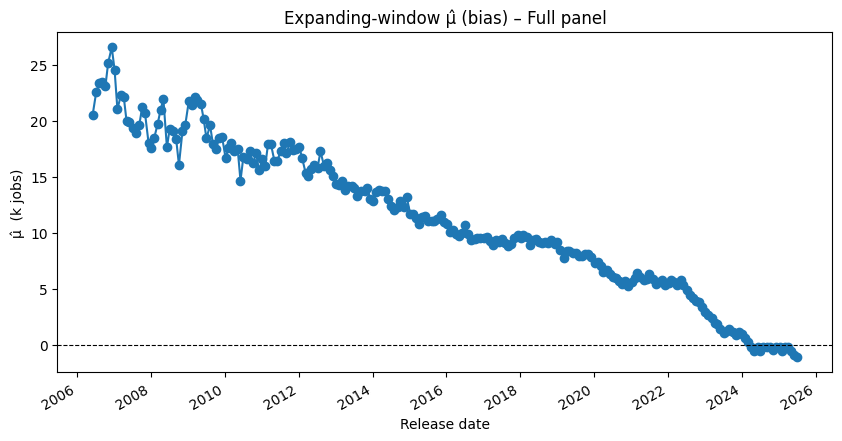

In [96]:
# -------------------------------------------------------------
# μ̂ diagnostics – Full panel • expanding-window Student-t
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

MIN_TRAIN = 36                     # releases before first fit

# ---------- aggregate release-level series ----------
per_rel = (df_full
           .groupby("release_date")
           .agg(median_fc=("median_forecast", "median"),
                actual    =("actual",          "first"))
           .reset_index()
           .sort_values("release_date"))
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]
per_rel = per_rel.dropna(subset=["actual"]).reset_index(drop=True)

# ---------- expanding-window μ̂ estimates ----------
mu_rec = []
for i in tqdm(range(MIN_TRAIN, len(per_rel)), desc="Full panel"):
    _, mu_hat, _ = st.t.fit(per_rel.loc[:i-1, "err"].values)
    mu_rec.append({"date": per_rel.at[i, "release_date"], "mu_hat": mu_hat})

mu_df = pd.DataFrame(mu_rec)

# ---------- summary stats ----------
print("\nμ̂ summary statistics (k jobs):")
print(mu_df["mu_hat"].describe().round(2))

# ---------- time-series plot ----------
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mu_df["date"], mu_df["mu_hat"], marker='o', color='tab:blue')
ax.axhline(0, color='black', lw=0.8, ls='--')
ax.set_title("Expanding-window μ̂ (bias) – Full panel")
ax.set_xlabel("Release date")
ax.set_ylabel("μ̂  (k jobs)")
fig.autofmt_xdate()
plt.show()


Rolling μ̂ | window=12:   0%|          | 0/254 [00:00<?, ?it/s]

Rolling μ̂ | window=36:   0%|          | 0/230 [00:00<?, ?it/s]


Rolling-window μ̂ summary (k jobs):
        count  mean    std     min    25%   50%    75%     max
window                                                        
12      254.0  2.38  31.32 -101.54 -10.16  2.12  16.32  131.79
36      230.0 -3.96  21.24  -56.65 -11.70  0.55  12.06   33.85


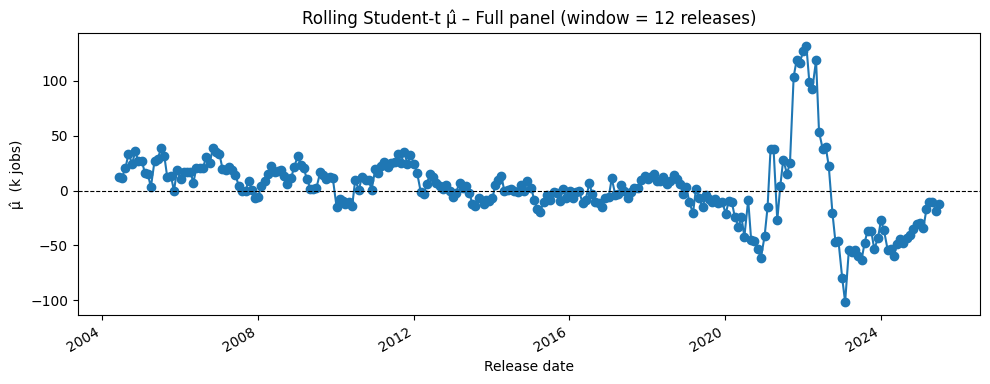

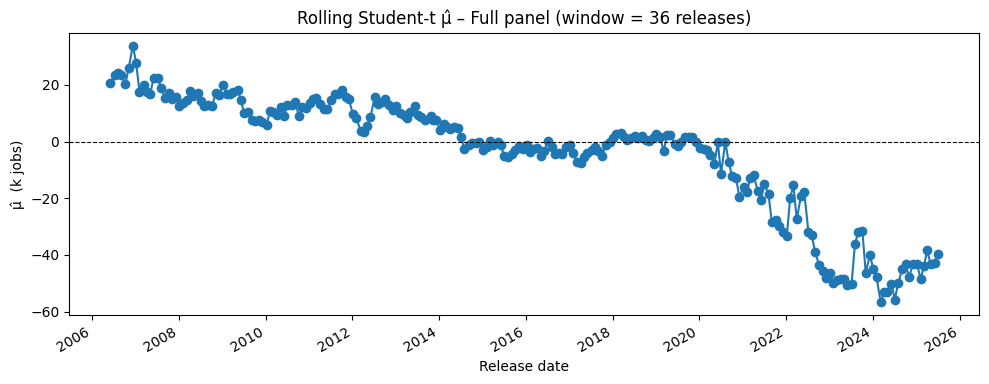

In [97]:
# -------------------------------------------------------------
# μ̂ diagnostics – Full panel • rolling Student-t
#           two independent figures (12- & 36-release windows)
# -------------------------------------------------------------
import numpy as np, pandas as pd, scipy.stats as st, warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.seterr(all="ignore")

ROLL_WINS = [12, 36]               # ≈ 1-yr and 3-yr windows

# ---------- build release-level error series ----------
rel_df = (df_full
          .groupby("release_date")
          .agg(median_fc=("median_forecast", "median"),
               actual    =("actual",          "first"))
          .reset_index()
          .sort_values("release_date"))
rel_df["err"] = rel_df["median_fc"] - rel_df["actual"]
rel_df = rel_df.dropna(subset=["actual"]).reset_index(drop=True)

# ---------- rolling μ̂ and summary ----------
mu_records = []
for win in ROLL_WINS:
    for i in tqdm(range(win, len(rel_df)),
                  desc=f"Rolling μ̂ | window={win}", leave=False):
        errs = rel_df.loc[i-win:i-1, "err"].values
        _, mu_hat, _ = st.t.fit(errs)
        mu_records.append({"window": win,
                           "date"  : rel_df.at[i, "release_date"],
                           "mu_hat": mu_hat})

mu_df = pd.DataFrame(mu_records)

print("\nRolling-window μ̂ summary (k jobs):")
print(mu_df.groupby("window")["mu_hat"].describe().round(2))

# ---------- separate figures ----------
for win in ROLL_WINS:
    sub = mu_df[mu_df["window"] == win]
    plt.figure(figsize=(10, 4))
    plt.plot(sub["date"], sub["mu_hat"], marker='o', color='#1f77b4')
    plt.axhline(0, color='black', lw=0.8, ls='--')
    plt.title(f"Rolling Student-t μ̂ – Full panel (window = {win} releases)")
    plt.xlabel("Release date")
    plt.ylabel("μ̂  (k jobs)")
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


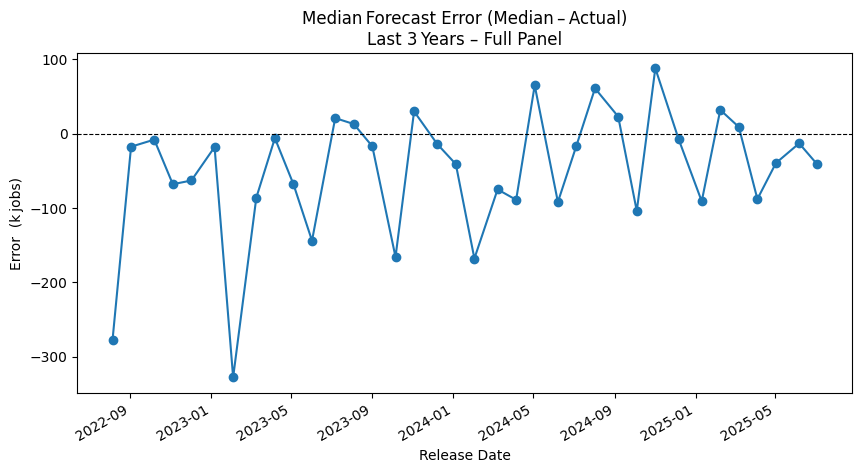

In [98]:
# let's visualize the recent prediction errors (consensus(median) - actual)

# 1. Compute the error series
per_rel = (df_full.groupby("release_date")
                     .agg(median_fc=("median_forecast", "median"),
                          actual=("actual", "first"))
                     .reset_index()
                     .sort_values("release_date"))

per_rel["error"] = per_rel["median_fc"] - per_rel["actual"]

# 2. Filter to the last 3 years
latest_date = per_rel["release_date"].max()
cutoff_date = latest_date - pd.DateOffset(years=3)
last3y = per_rel[per_rel["release_date"] >= cutoff_date]

# 3. Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(last3y["release_date"], last3y["error"], marker="o")
ax.axhline(0, color="black", lw=0.8, ls="--")
ax.set_title("Median Forecast Error (Median – Actual)\nLast 3 Years – Full Panel")
ax.set_xlabel("Release Date")
ax.set_ylabel("Error  (k jobs)")
fig.autofmt_xdate()
plt.show()


**Firm-level coverage**

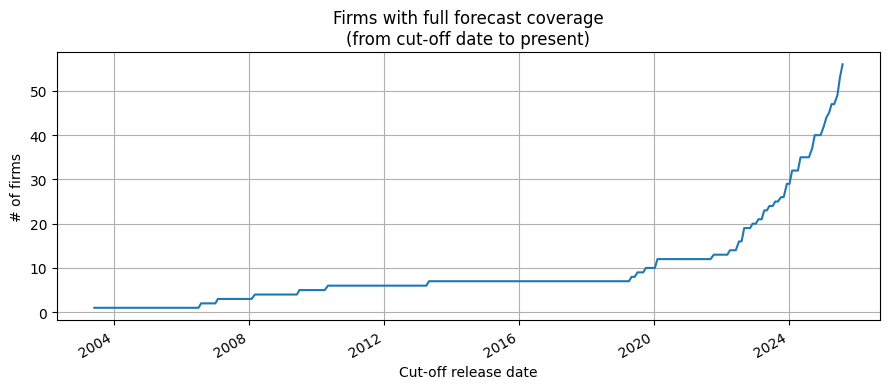


Number of firms with contiguous history (first release of each year):


,n_firms
release_date,
2003,1
2004,1
2005,1
2006,1
2007,2
2008,3
2009,4
2010,5
2011,6



Firms with full coverage since 2010-01-01 (5):


,firm
0,First Trust Portfolios LP
1,JP Morgan Securities LLC
2,National Bank of Canada Financial Inc
3,Wells Fargo Bank NA
4,Wrightson ICAP LLC



Monthly additions to the contiguous-coverage pool (2010 → present):


,new_firms,n_new
month,,
2010-05-01,[Santander US Capital Markets LLC],1
2013-05-01,[Regions Bank],1
2019-05-01,[Visa USA Inc],1
2019-07-01,[TD Securities USA LLC],1
2019-10-01,[4CAST/Continuum Economics],1
2020-02-01,"[Prestige Economics LLC, High Frequency Econom...",2
2021-10-01,[HSBC Securities USA Inc],1
2022-04-01,[Action Economics LLC],1
2022-07-01,"[RSM US LLp, Lloyds Bank PLC]",2


In [ ]:
# -build coverage boolean panel 
coverage = (
    df_firms_full.assign(flag=1)
        .pivot_table(index='firm',
                     columns='release_date',
                     values='flag',
                     aggfunc='size')
        .notna()                       # True = forecast exists
        .sort_index(axis=1)            # chronological columns
)

full_cov = (
    coverage.iloc[:, ::-1]            # walk right to left
            .cumprod(axis=1)          # 1-cumprod = logical-AND
            .astype(bool)
            .iloc[:, ::-1]            # back to chronological order
)

# Plot firms with full coverage 
coverage_counts = full_cov.sum(axis=0)

plt.figure(figsize=(9, 4))
coverage_counts.plot()
plt.title('Firms with full forecast coverage\n(from cut-off date to present)')
plt.ylabel('# of firms')
plt.xlabel('Cut-off release date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Yearly snapshot table
yearly = (
    coverage_counts
        .groupby(coverage_counts.index.year)
        .first()                      # first release each year
        .rename('n_firms')
)

print("\nNumber of firms with contiguous history (first release of each year):")
display(yearly.to_frame())

# contiguous firm helper
def contiguous_firms_since(start):
    """List firms with no missing forecasts from `start` onward."""
    start_ts = pd.Timestamp(f"{start}-01-01") if isinstance(start, int) else pd.Timestamp(start)
    cols = full_cov.columns[full_cov.columns >= start_ts]
    return full_cov[cols].all(axis=1).loc[lambda s: s].index.tolist()

firms_2010 = sorted(contiguous_firms_since(2010))
print(f"\nFirms with full coverage since 2010-01-01 ({len(firms_2010)}):")
display(pd.DataFrame({'firm': firms_2010}))

# monthly additions to coverage pool
first_full_dates = (
    full_cov.apply(lambda row: row.idxmax() if row.any() else pd.NaT, axis=1)
            .dropna()
            .rename('date_added')
)

additions = (
    first_full_dates[first_full_dates >= pd.Timestamp('2010-01-01')]
        .reset_index()                # columns: firm, date_added
        .sort_values('date_added')
)

monthly_additions = (
    additions.assign(month=lambda df: df['date_added'].dt.to_period('M').dt.to_timestamp())
             .groupby('month')['firm']
             .apply(list)             # newcomers that month
             .to_frame('new_firms')
             .assign(n_new=lambda df: df['new_firms'].str.len())
)

print("\nMonthly additions to the contiguous-coverage pool (2010 → present):")
display(monthly_additions)

Best cumulative hit-rate from each rolling-origin window (contiguous-coverage firms only):


,start_year,best_hit_rate,top_firm(s),#_obs
0,2010,0.484,First Trust Portfolios LP,188
1,2011,0.494,"First Trust Portfolios LP, Santander US Capita...","176, 176"
2,2012,0.500,"First Trust Portfolios LP, Santander US Capita...","164, 164"
3,2013,0.520,Santander US Capital Markets LLC,152
4,2014,0.543,Santander US Capital Markets LLC,140
5,2015,0.523,Santander US Capital Markets LLC,128
6,2016,0.543,Santander US Capital Markets LLC,116
7,2017,0.558,Santander US Capital Markets LLC,104
8,2018,0.576,Santander US Capital Markets LLC,92
9,2019,0.612,Santander US Capital Markets LLC,80


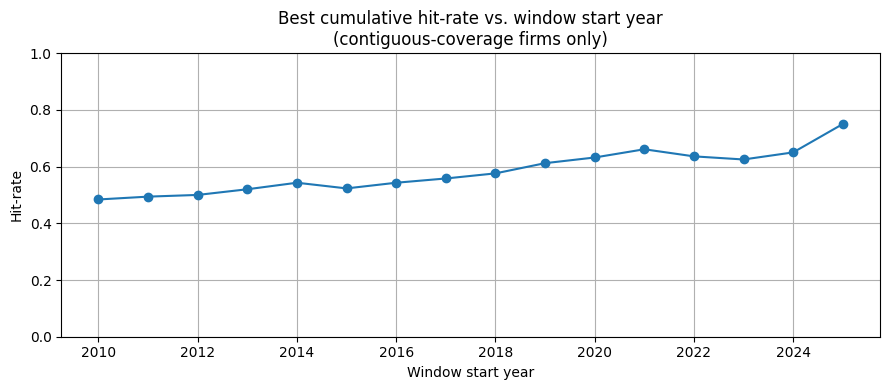

In [ ]:
# vectorized per hit row flag
# Direction: +1 beat, −1 miss, 0 tie.  NaN actual → label 0.
dir_fore = np.sign(df_firms_full['forecast'] - df_firms_full['median_forecast'])
dir_act  = np.sign(df_firms_full['actual']   - df_firms_full['median_forecast']).fillna(0)

df_firms_full = df_firms_full.assign(hit = (dir_fore == dir_act) & (dir_act != 0))


def contiguous_firms_since(start_year: int):
    """
    Returns a contiguous coverage list for a given start year 
    """
    start_ts = pd.Timestamp(f"{start_year}-01-01")
    cols = full_cov.columns[full_cov.columns >= start_ts]
    return (
        full_cov[cols].all(axis=1)
                      .loc[lambda s: s]          # only True rows
                      .index.tolist()
    )

# ----------------------------------------------------------------
# 3.  Rolling-origin summary table -------------------------------
# ----------------------------------------------------------------
records = []
for y in range(2010, 2026):                      # 2010 … 2025-YTD
    firms = contiguous_firms_since(y)
    if not firms:
        continue                                 # no qualifying firms

    mask = (df_firms_full['release_date'] >= f'{y}-01-01') \
           & df_firms_full['firm'].isin(firms)
    wnd = df_firms_full.loc[mask]

    # per-firm cumulative hit-rate
    rates = wnd.groupby('firm')['hit'].mean()

    if rates.empty:
        continue

    best_rate = rates.max()
    winners   = rates[rates == best_rate].index.tolist()
    n_obs     = wnd.groupby('firm').size().loc[winners].tolist()

    records.append({
        'start_year'   : y,
        'best_hit_rate': round(best_rate, 3),
        'top_firm(s)'  : ', '.join(winners),
        '#_obs'        : ', '.join(map(str, n_obs)),
    })

best_hit_since = pd.DataFrame(records)

# ----------------------------------------------------------------
# 4.  Display table and quick plot -------------------------------
# ----------------------------------------------------------------
print("Best cumulative hit-rate from each rolling-origin window (contiguous-coverage firms only):")
display(best_hit_since)

plt.figure(figsize=(9, 4))
plt.plot(best_hit_since['start_year'], best_hit_since['best_hit_rate'], marker='o')
plt.title('Best cumulative hit-rate vs. window start year\n(contiguous-coverage firms only)')
plt.xlabel('Window start year')
plt.ylabel('Hit-rate')
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
